# Introduction to Physics-Informed Neural Networks (PINNs)

This tutorial introduces Physics-Informed Neural Networks (PINNs), a powerful class of neural networks that leverage the underlying physics of a system, described by Partial Differential Equations (PDEs) or Ordinary Differential Equations (ODEs), directly within the training process.

We will cover:
- **The Core Idea of PINNs:** How physical laws are incorporated into the loss function.
- **Example 1: Solving a 1D ODE:** We'll train a network to find the solution $u(x)$ for $u''(x) = -\sin(x)$ with boundary conditions $u(0)=0$ and $u(2\pi)=0$, *without* explicitly providing the solution $u(x) = \sin(x)$ during training.
- **Extension to PDEs:** Briefly discussing how PINNs handle more complex problems like the time-dependent Burger's equation.
- **Inverse Problems:** How PINNs can infer physical parameters (like viscosity) from observed data.

## 1. The Core Idea of PINNs

Traditional neural networks as we had seen in the earlier tutorial learn mappings from input to output based purely on data examples (`(input, target)` pairs). PINNs go a step further by incorporating knowledge of the physical laws governing the system.

The central idea is to train a neural network (often an MLP) such that its output $u_{\mathrm{pred}}(x, t)$ not only matches known data points (like boundary conditions or initial conditions) but also satisfies the governing differential equation(s).

This is achieved through a composite **loss function**:

\begin{align}

\mathcal{L}_{\mathrm{total}} = \mathcal{L}_{\mathrm{data}} + \lambda \cdot \mathcal{L}_{\mathrm{physics}}

\end{align}

*   **$\mathcal{L}_{\mathrm{data}}$**: Measures the mismatch between the network's predictions and known data points. This often includes:
    *   Boundary Conditions (BCs): e.g., $u(x=0) = 0$.
    *   Initial Conditions (ICs): e.g., $u(t=0) = u_0$.
    *   Sparse sensor measurements within the domain.
*   **$\mathcal{L}_{\mathrm{physics}}$**: Measures how well the network's output satisfies the governing differential equation(s). It's calculated based on the **residual** of the PDE/ODE. For an equation $F(u, \partial_x u, \partial_t u, ..., x, t) = 0$, the residual is $r(x, t) = F(u_{\mathrm{pred}}, \partial_x u_{\mathrm{pred}}, \partial_t u_{\mathrm{pred}}, ..., x, t)$. The physics loss aims to minimize this residual (e.g., $\mathcal{L}_{\mathrm{physics}} = \|r\|_2^2$).
*   **$\lambda$**: A weighting factor (hyperparameter) to balance the contribution of the physics loss relative to the data loss.

Critically, PINNs rely heavily on **Automatic Differentiation (AD)**, a capability built into frameworks like PyTorch, to compute the necessary derivatives (like $\partial_x u_{\mathrm{pred}}$, $\partial_t u_{\mathrm{pred}}$) of the network's output $u_{\mathrm{pred}}$ with respect to its inputs ($x$, $t$). Recall that in the previous exercise we had used autodiff to compute the gradient with respect to the parameters of the network. However, we can also leverage AD to compute the gradient with respect to the inputs of the network.

## 2. Example: Solving $u''(x) = -\sin(x)$

Let's find the function $u(x)$ that satisfies:
*   **ODE:** $u''(x) = -\sin(x)$ for $x$ in $[0, 2\pi]$
*   **Boundary Conditions (BCs):** $u(0) = 0$ and $u(2\pi) = 0$

We know the analytical solution is $u(x) = \sin(x)$. However, we will *not* use this knowledge directly in the training loss. We will only use the ODE itself and the BCs. The network must *infer* the $\sin(x)$ solution.

We'll use a similar MLP structure from the previous tutorial.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import wandb
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(123)
np.random.seed(123)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation=nn.Tanh):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.activation1 = activation()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.activation2 = activation()
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.activation3 = activation()
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.layer2(x)
        x = self.activation2(x)
        x = self.layer3(x)
        x = self.activation3(x)
        x = self.output_layer(x)
        return x

/opt/anaconda3/envs/mlenv/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Using device: cpu


We need points for two purposes:
1.  **Boundary Points (`x_bc`):** Where we know the value of $u(x)$ (at $x=0$ and $x=2\pi$).
2.  **Collocation Points (`x_f`):** Points distributed *inside* the domain $(0, 2\pi)$ where we will enforce the ODE $u''(x) + \sin(x) = 0$. We don't know $u(x)$ at these points, only that the ODE must hold.

In [2]:
# Boundary points
x_bc_np = np.array([[0.0], [2.0 * np.pi]])
u_bc_np = np.array([[0.0], [0.0]])  # Target values at boundaries

x_bc = torch.tensor(x_bc_np, dtype=torch.float32).to(device)
u_bc = torch.tensor(u_bc_np, dtype=torch.float32).to(device)

# Collocation points for physics loss
num_collocation = 1000
# Use linspace for uniform distribution, could also use random sampling
x_f_np = np.linspace(0, 2 * np.pi, num_collocation, endpoint=True).reshape(-1, 1)
x_f = torch.tensor(x_f_np, dtype=torch.float32).to(device).requires_grad_(True)

Now, we can just move on to defining the training loop.

In [3]:
# Loss function for data (BCs) - Mean Squared Error
mse_loss = nn.MSELoss()
def physics_loss(model, x_f):
    """Calculates the physics-based loss"""
    # Predict u(x) at collocation points
    u_pred = model(x_f)

    # Calculate derivatives using automatic differentiation
    # First derivative: du/dx
    u_x = torch.autograd.grad(
        u_pred,
        x_f,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True,
    )[0]

    # Second derivative: d^2u/dx^2
    u_xx = torch.autograd.grad(
        u_x, x_f, grad_outputs=torch.ones_like(u_x), create_graph=True
    )[0]

    # Calculate the residual of the ODE: u'' + sin(x) = 0
    f_target = -torch.sin(x_f)
    residual = u_xx - f_target  # Should be close to zero if ODE is satisfied

    # Calculate the MSE of the residual (aim for residual = 0)
    loss_f = mse_loss(residual, torch.zeros_like(residual))
    return loss_f

In [4]:
net_config = {
    "input_size": 1,
    "hidden_size": 64,
    "output_size": 1,
    "activation": nn.Tanh,
}

config = {
    "net_config": net_config,
    "optimizer_config": {
        "lr": 1e-3,
    },
    "lambda_f": 1.0,
    "num_epochs": 20000,
}

model = MLP(**net_config).to(device)
print("Model Architecture:")
print(model)
optimizer = optim.Adam(model.parameters(), **config["optimizer_config"])

# Weight for the physics loss
lambda_f = config["lambda_f"]

num_epochs = config["num_epochs"]
print_every = 1000

losses_total = []
losses_bc = []
losses_f = []

print("\nStarting PINN Training...")

wandb.init(project="ai4science_tutorial", config=config)
for epoch in range(num_epochs):
    model.train()

    # --- Calculate Data Loss (Boundary Conditions) ---
    u_pred_bc = model(x_bc)
    loss_bc = mse_loss(u_pred_bc, u_bc)

    # --- Calculate Physics Loss (ODE Residual) ---
    loss_f = physics_loss(model, x_f)

    # --- Total Loss ---
    loss = loss_bc + lambda_f * loss_f

    # --- Backpropagation and Optimization ---
    optimizer.zero_grad()
    loss.backward()  # Compute gradients of total loss w.r.t. parameters
    optimizer.step()

    # --- Logging ---
    losses_total.append(loss.item())
    losses_bc.append(loss_bc.item())
    losses_f.append(loss_f.item())

    if (epoch + 1) % print_every == 0:
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f} "
            f"(BC: {loss_bc.item():.6f}, Physics: {loss_f.item():.6f})"
        )

        wandb.log({
            "loss": loss.item(),
            "loss_bc": loss_bc.item(),
            "loss_f": loss_f.item(),
        })

print("Training Finished!")
wandb.finish()

Model Architecture:
MLP(
  (layer1): Linear(in_features=1, out_features=64, bias=True)
  (activation1): Tanh()
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (activation2): Tanh()
  (layer3): Linear(in_features=64, out_features=64, bias=True)
  (activation3): Tanh()
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.



Starting PINN Training...


wandb: Currently logged in as: hyperion to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch [1000/20000], Loss: 0.000104 (BC: 0.000000, Physics: 0.000104)
Epoch [2000/20000], Loss: 0.000022 (BC: 0.000000, Physics: 0.000022)
Epoch [3000/20000], Loss: 0.000001 (BC: 0.000000, Physics: 0.000001)
Epoch [4000/20000], Loss: 0.000964 (BC: 0.000877, Physics: 0.000087)
Epoch [5000/20000], Loss: 0.000002 (BC: 0.000000, Physics: 0.000002)
Epoch [6000/20000], Loss: 0.000061 (BC: 0.000058, Physics: 0.000003)
Epoch [7000/20000], Loss: 0.000001 (BC: 0.000000, Physics: 0.000001)
Epoch [8000/20000], Loss: 0.000012 (BC: 0.000010, Physics: 0.000002)
Epoch [9000/20000], Loss: 0.000003 (BC: 0.000002, Physics: 0.000001)
Epoch [10000/20000], Loss: 0.000000 (BC: 0.000000, Physics: 0.000000)
Epoch [11000/20000], Loss: 0.000001 (BC: 0.000000, Physics: 0.000000)
Epoch [12000/20000], Loss: 0.000065 (BC: 0.000059, Physics: 0.000006)
Epoch [13000/20000], Loss: 0.000002 (BC: 0.000001, Physics: 0.000000)
Epoch [14000/20000], Loss: 0.000000 (BC: 0.000000, Physics: 0.000000)
Epoch [15000/20000], Loss: 0.

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch [20000/20000], Loss: 0.000002 (BC: 0.000002, Physics: 0.000001)
Training Finished!


loss,▂▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
loss_bc,▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
loss_f,█▂▁▇▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁
loss,0.0
loss_bc,0.0
loss_f,0.0


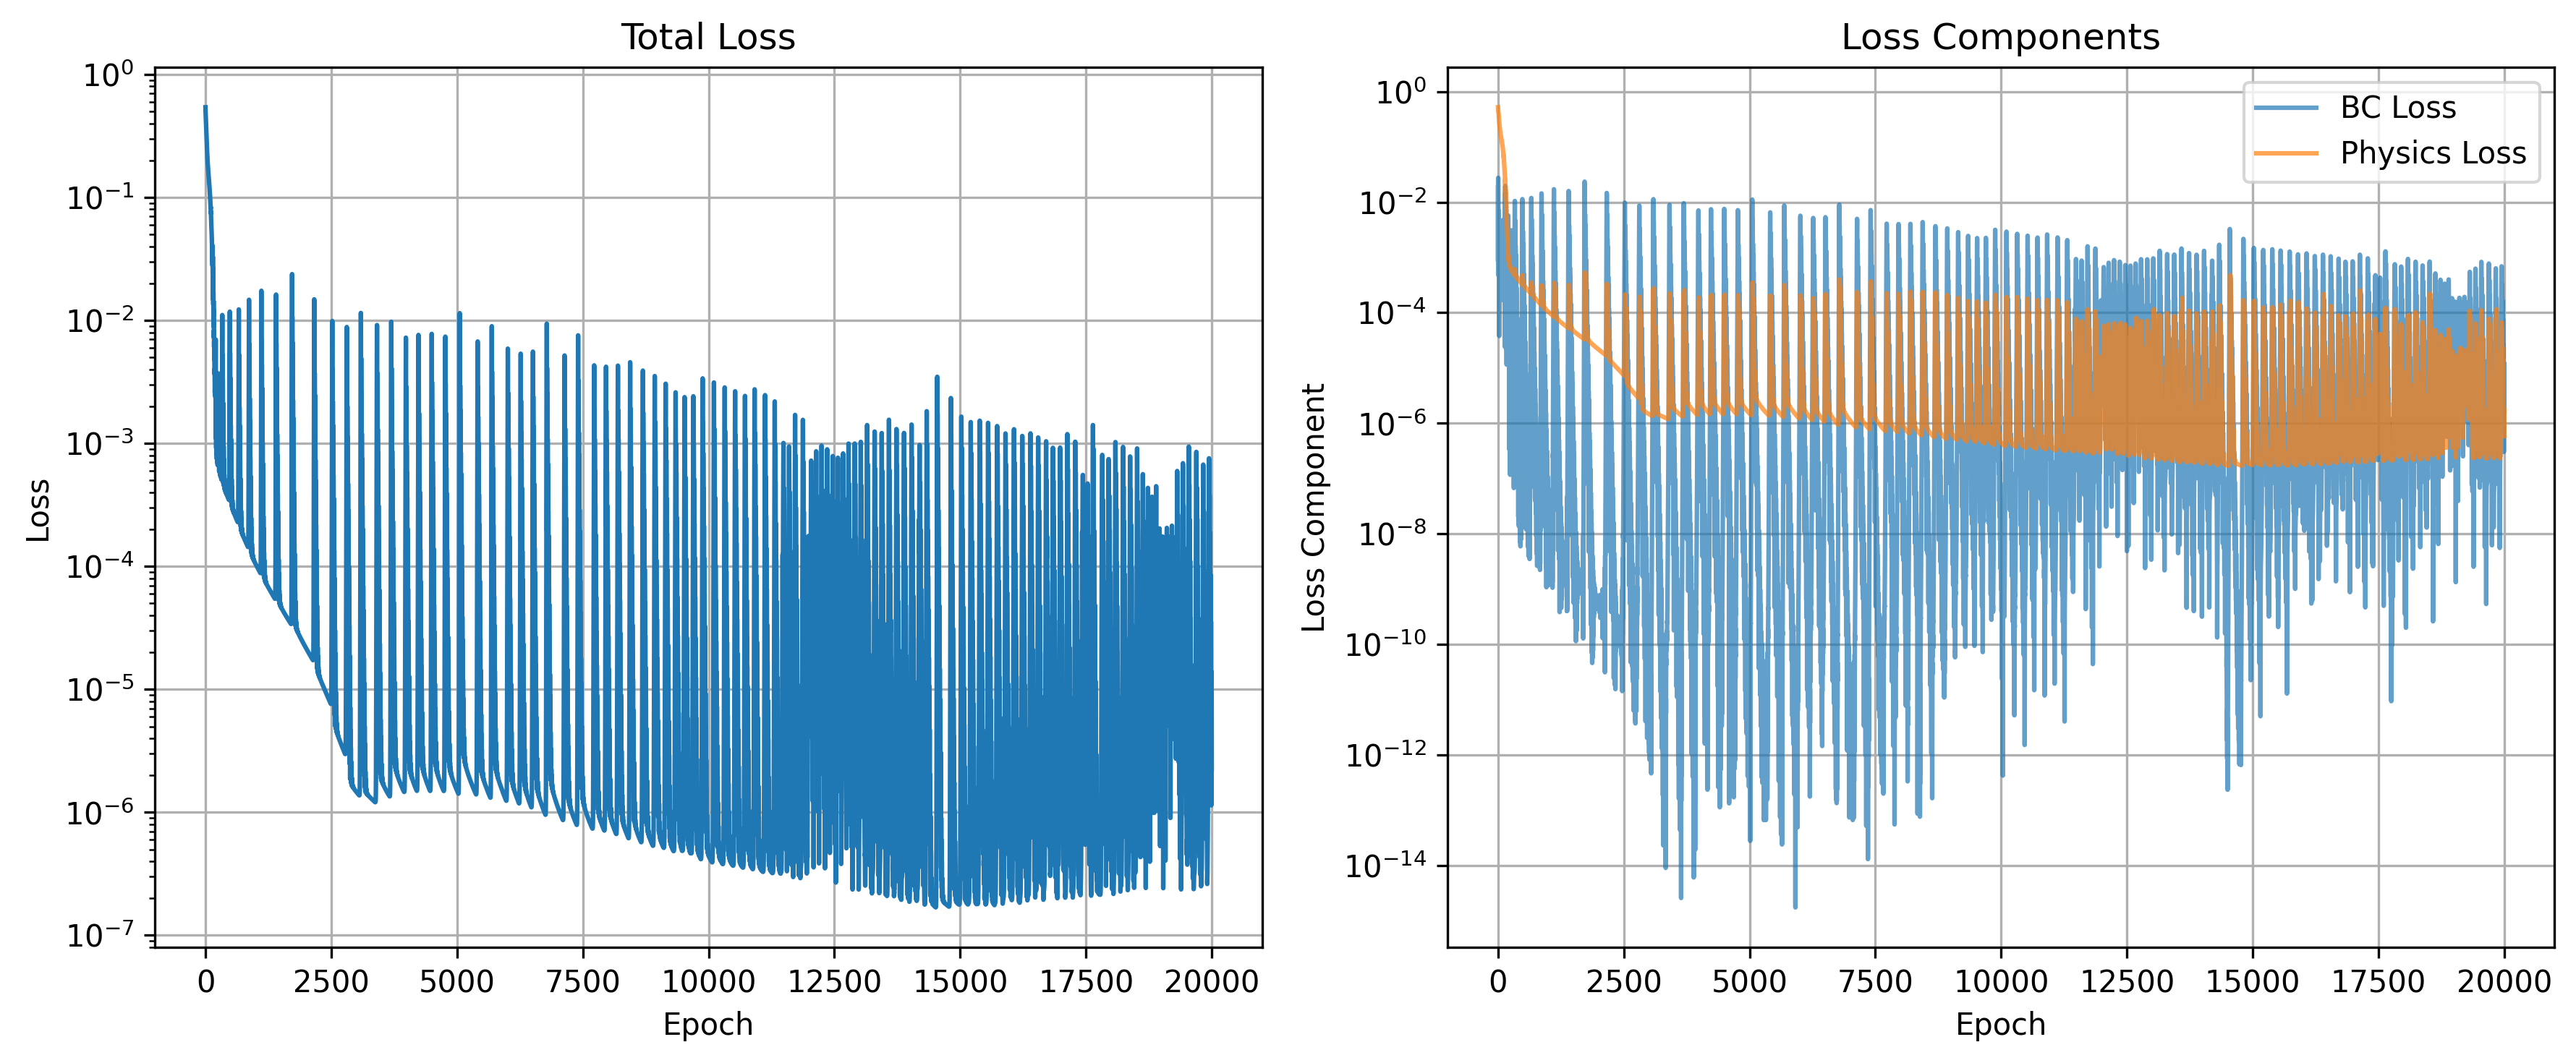

In [5]:
# Plot losses
plt.figure(figsize=(12, 5), dpi=300)
plt.subplot(1, 2, 1)
plt.plot(losses_total, label="Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Total Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(losses_bc, label="BC Loss", alpha=0.7)
plt.plot(losses_f, label="Physics Loss", alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Loss Component")
plt.yscale("log")
plt.title("Loss Components")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Now, let's compare the PINN's prediction `u_pred(x)` against the *actual* analytical solution `u(x) = sin(x)`, which the network hasn't seen during training.

In [6]:
# Generate points for evaluation
x_eval_np = np.linspace(0, 2 * np.pi, 200).reshape(-1, 1)
x_eval = torch.tensor(x_eval_np, dtype=torch.float32).to(device)

# Get predictions from the trained model
model.eval()
with torch.no_grad():
    u_pred_eval = model(x_eval)

# Get the analytical solution for comparison
u_analytical = np.sin(x_eval_np)

# Move prediction to CPU for plotting
u_pred_eval_np = u_pred_eval.cpu().numpy()

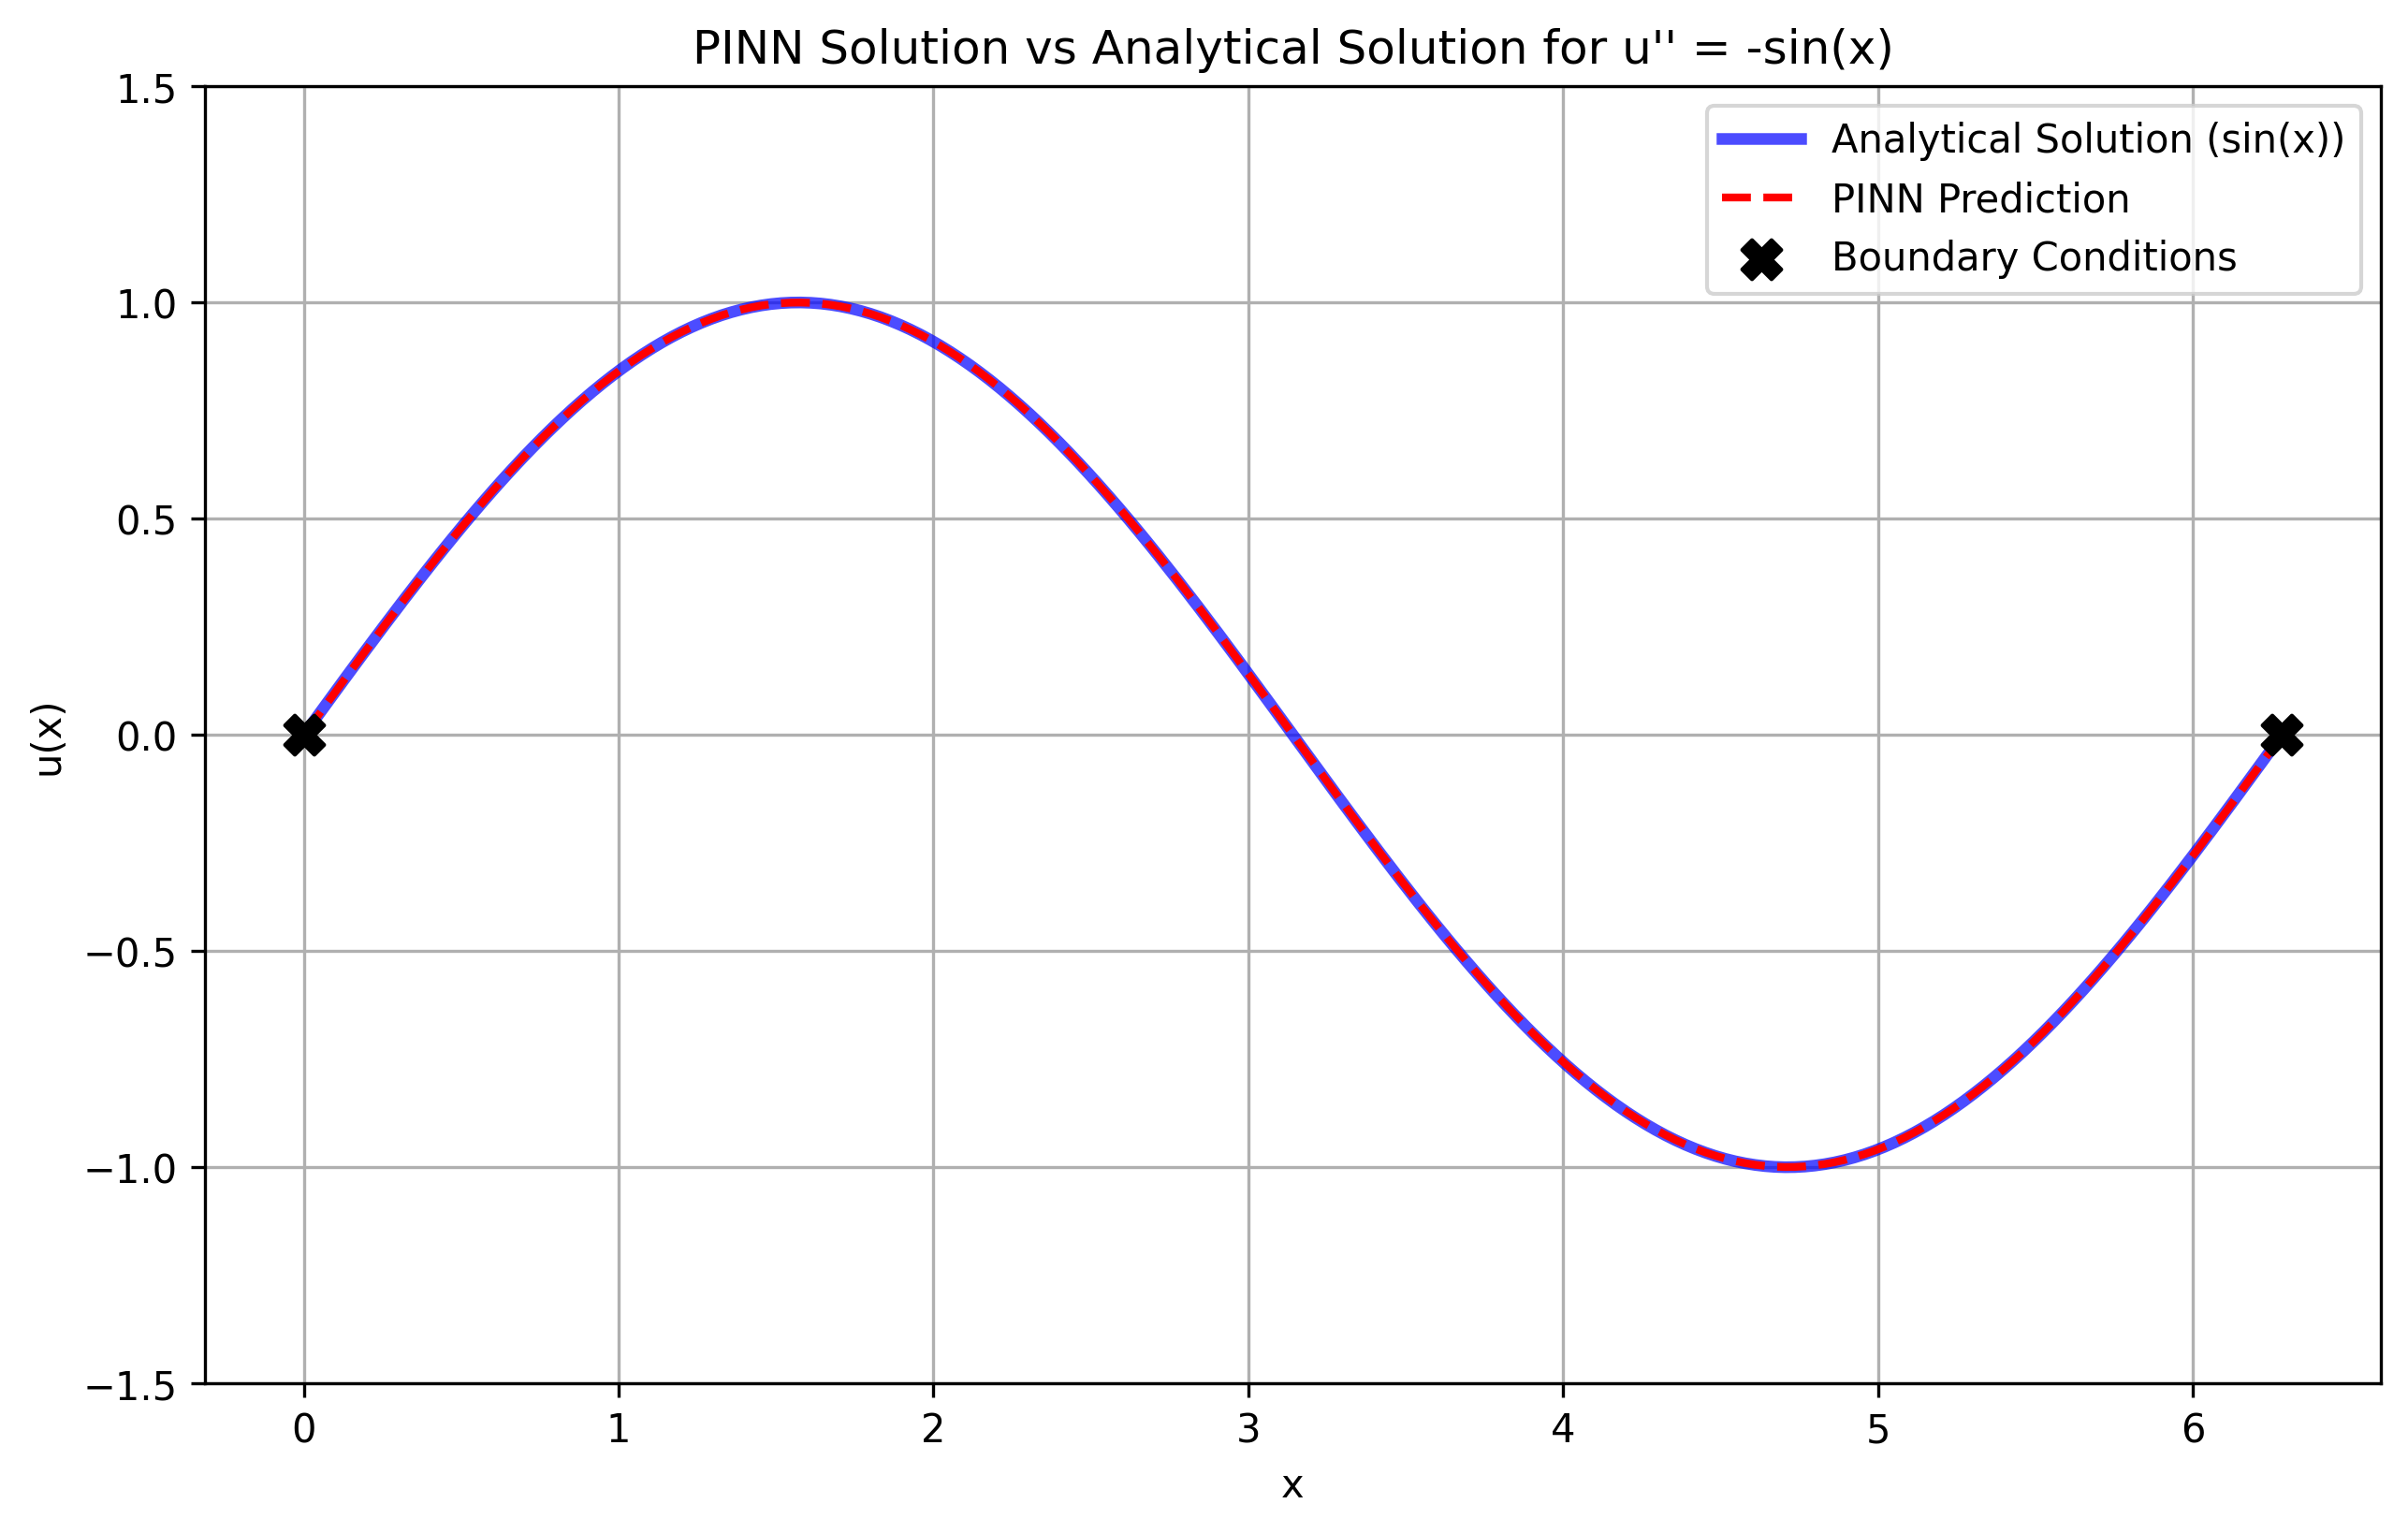

In [7]:
# Plot the results
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(
    x_eval_np,
    u_analytical,
    label="Analytical Solution (sin(x))",
    linewidth=3,
    color="blue",
    alpha=0.7,
)
plt.plot(
    x_eval_np,
    u_pred_eval_np,
    label="PINN Prediction",
    linewidth=2,
    color="red",
    linestyle="--",
)
# Also plot the boundary points used in training
plt.scatter(
    x_bc_np,
    u_bc_np,
    label="Boundary Conditions",
    color="black",
    marker="X",
    s=100,
    zorder=5,
)
plt.title("PINN Solution vs Analytical Solution for u'' = -sin(x)")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.ylim(-1.5, 1.5)
plt.show()

In [8]:

# Calculate Mean Squared Error against analytical solution
eval_mse = np.mean((u_pred_eval_np - u_analytical) ** 2)
print(f"Mean Squared Error on evaluation points: {eval_mse:.2e}")
# Also computing the relative L2 error
relative_l2_error = np.linalg.norm(u_pred_eval_np - u_analytical) / np.linalg.norm(u_analytical)
print(f"Relative L2 Error on evaluation points: {relative_l2_error:.2e}")

Mean Squared Error on evaluation points: 1.69e-07
Relative L2 Error on evaluation points: 5.83e-04


## 3. Extension to PDEs: Burger's Equation Example

The same principle extends to Partial Differential Equations (PDEs) involving multiple independent variables (like space $x$ and time $t$).

Consider the 1D viscous Burger's equation:
\begin{align}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{align}

*   **Input:** The network takes $(t, x)$ as input.
*   **Output:** The network predicts $u(t, x)$.
*   **Derivatives:** Automatic differentiation computes $\frac{\partial u}{\partial t}$, $\frac{\partial u}{\partial x}$, and $\frac{\partial^2 u}{\partial x^2}$ from the network output $u_{pred}(t, x)$.
*   **Physics Loss:** The residual is $r = \frac{\partial u_{\mathrm{pred}}}{\partial t} + u_{\mathrm{pred}} \frac{\partial u_{\mathrm{pred}}}{\partial x} - \nu \frac{\partial^2 u_{\mathrm{pred}}}{\partial x^2}$. The loss is $\mathrm{MSE}(r, 0)$, calculated at collocation points $(t, x)$ sampled within the spatio-temporal domain.
*   **Data Loss:** Comes from Initial Conditions (ICs) like $u(0, x) = u_0(x)$ and Boundary Conditions (BCs) like $u(t, x_{\mathrm{min}}) = \mathrm{BC}_{\mathrm{min}}(t)$ and $u(t, x_{\mathrm{max}}) = \mathrm{BC}_{\mathrm{max}}(t)$.
*   **$\nu$ (Viscosity):** This is a physical parameter, which can be known and fixed (as in the forward problem setting), or unknown and inferred (as in the inverse problem setting as we'll see in the next section).

First let's define the specific problem that we want to solve:

*   Domain: $t \in [0, 1]$, $x \in [-1, 1]$
*   Initial Condition (IC): $u(0, x) = -\sin(\pi x)$
*   Boundary Conditions (BCs): $u(t, -1) = 0$, $u(t, 1) = 0$ (Dirichlet)
*   Viscosity $\nu$: We'll set a true value for generating data and for the forward problem. Let $\nu_{true} = 0.01 / \pi$.

In [9]:
# Domain bounds
t_min, t_max = 0.0, 1.0
x_min, x_max = -1.0, 1.0

# True Viscosity
nu_true = 0.01 / np.pi

Now, we train the network to find `u(t, x)` by minimizing the combined loss from ICs, BCs, and the PDE residual.

In [10]:
num_ic = 200  # Points for initial condition
num_bc = 200  # Points for each boundary (left/right)
num_f = 10000  # Collocation points for physics residual

# Initial Condition points (t=0)
t_ic = torch.zeros((num_ic, 1), device=device)
x_ic = torch.linspace(x_min, x_max, num_ic).view(-1, 1).to(device)
# Target u values at t=0
u_ic = -torch.sin(np.pi * x_ic)

# Boundary Condition points (x=-1 and x=1)
t_bc = torch.rand((num_bc, 1), device=device) * t_max  # Random times
x_bc_left = torch.full((num_bc // 2, 1), x_min, device=device)
x_bc_right = torch.full((num_bc // 2, 1), x_max, device=device)
t_bc_left = torch.rand((num_bc // 2, 1), device=device) * t_max
t_bc_right = torch.rand((num_bc // 2, 1), device=device) * t_max
# Combine left and right BC points
x_bc = torch.cat([x_bc_left, x_bc_right], dim=0)
t_bc = torch.cat([t_bc_left, t_bc_right], dim=0)
# Target u values at boundaries (both are 0)
u_bc = torch.zeros((num_bc, 1), device=device)

# Collocation points (inside the domain, for physics loss)
t_f = torch.rand((num_f, 1), device=device) * t_max
x_f = torch.rand((num_f, 1), device=device) * (x_max - x_min) + x_min
# Make requires_grad=True for physics loss calculation
t_f.requires_grad_(True)
x_f.requires_grad_(True)

print(f"Generated {num_ic} IC points, {num_bc} BC points, {num_f} collocation points.")

Generated 200 IC points, 200 BC points, 10000 collocation points.


In [11]:
mse_loss = nn.MSELoss()
def physics_loss_forward(model, t_f, x_f, nu):
    """Calculates the physics-based loss for Burger's equation"""
    # Combine t and x, predict u
    tx_f = torch.cat([t_f, x_f], dim=1)
    u_pred = model(tx_f)

    # Calculate derivatives using automatic differentiation
    # u_t
    u_t = torch.autograd.grad(
        u_pred, t_f, grad_outputs=torch.ones_like(u_pred), create_graph=True
    )[0]

    # u_x
    u_x = torch.autograd.grad(
        u_pred, x_f, grad_outputs=torch.ones_like(u_pred), create_graph=True
    )[0]

    # u_xx
    u_xx = torch.autograd.grad(
        u_x, x_f, grad_outputs=torch.ones_like(u_x), create_graph=True
    )[0]

    # Calculate the residual of Burger's equation: u_t + u * u_x - nu * u_xx = 0
    residual = u_t + u_pred * u_x - nu * u_xx

    # Calculate the MSE of the residual (aim for residual = 0)
    loss_f = mse_loss(residual, torch.zeros_like(residual))
    return loss_f

In [12]:
input_dim = 2
hidden_dim = 256
output_dim = 1

# Re-initialize model and optimizer for forward problem
model_forward = MLP(input_dim, hidden_dim, output_dim).to(device)
optimizer_forward = optim.Adam(model_forward.parameters(), lr=1e-4)

# Loss weights (can be tuned)
lambda_ic = 1.0
lambda_bc = 1.0
lambda_f = 1.0

num_epochs_forward = 20000
print_every_forward = 1000

losses_fwd_total = []
losses_fwd_ic = []
losses_fwd_bc = []
losses_fwd_f = []

print("\n--- Starting Forward Problem Training ---")
start_time = time.time()

for epoch in range(num_epochs_forward):
    model_forward.train()

    # Zero gradients
    optimizer_forward.zero_grad()

    # --- Calculate Data Losses (IC & BC) ---
    # IC Loss
    u_pred_ic = model_forward(torch.cat([t_ic, x_ic], dim=1))
    loss_ic = mse_loss(u_pred_ic, u_ic)

    # BC Loss
    u_pred_bc = model_forward(torch.cat([t_bc, x_bc], dim=1))
    loss_bc = mse_loss(u_pred_bc, u_bc)

    # --- Calculate Physics Loss ---
    loss_f = physics_loss_forward(model_forward, t_f, x_f, nu_true)  # Use fixed nu_true

    # --- Total Loss ---
    loss = lambda_ic * loss_ic + lambda_bc * loss_bc + lambda_f * loss_f

    # --- Backpropagation and Optimization ---
    loss.backward()
    optimizer_forward.step()

    # --- Logging ---
    losses_fwd_total.append(loss.item())
    losses_fwd_ic.append(loss_ic.item())
    losses_fwd_bc.append(loss_bc.item())
    losses_fwd_f.append(loss_f.item())

    if (epoch + 1) % print_every_forward == 0:
        print(
            f"Fwd Epoch [{epoch + 1}/{num_epochs_forward}], Loss: {loss.item():.4e} "
            f"(IC: {loss_ic.item():.3e}, BC: {loss_bc.item():.3e}, Phys: {loss_f.item():.3e})"
        )

end_time = time.time()
print(f"Forward Training Finished! Time: {end_time - start_time:.2f} seconds")


--- Starting Forward Problem Training ---
Fwd Epoch [1000/20000], Loss: 9.1447e-02 (IC: 5.481e-02, BC: 4.816e-04, Phys: 3.616e-02)
Fwd Epoch [2000/20000], Loss: 7.6972e-02 (IC: 4.569e-02, BC: 1.505e-04, Phys: 3.113e-02)
Fwd Epoch [3000/20000], Loss: 4.4110e-02 (IC: 2.461e-02, BC: 6.561e-05, Phys: 1.944e-02)
Fwd Epoch [4000/20000], Loss: 2.3270e-02 (IC: 1.205e-02, BC: 5.422e-05, Phys: 1.116e-02)
Fwd Epoch [5000/20000], Loss: 1.5989e-02 (IC: 7.795e-03, BC: 5.081e-05, Phys: 8.143e-03)
Fwd Epoch [6000/20000], Loss: 1.1012e-02 (IC: 5.719e-03, BC: 3.578e-05, Phys: 5.257e-03)
Fwd Epoch [7000/20000], Loss: 8.1518e-03 (IC: 4.309e-03, BC: 2.446e-05, Phys: 3.818e-03)
Fwd Epoch [8000/20000], Loss: 6.5753e-03 (IC: 3.467e-03, BC: 1.695e-05, Phys: 3.092e-03)
Fwd Epoch [9000/20000], Loss: 7.1464e-03 (IC: 2.904e-03, BC: 1.839e-05, Phys: 4.224e-03)
Fwd Epoch [10000/20000], Loss: 4.7069e-03 (IC: 2.499e-03, BC: 1.040e-05, Phys: 2.198e-03)
Fwd Epoch [11000/20000], Loss: 3.9469e-03 (IC: 2.108e-03, BC: 8.41

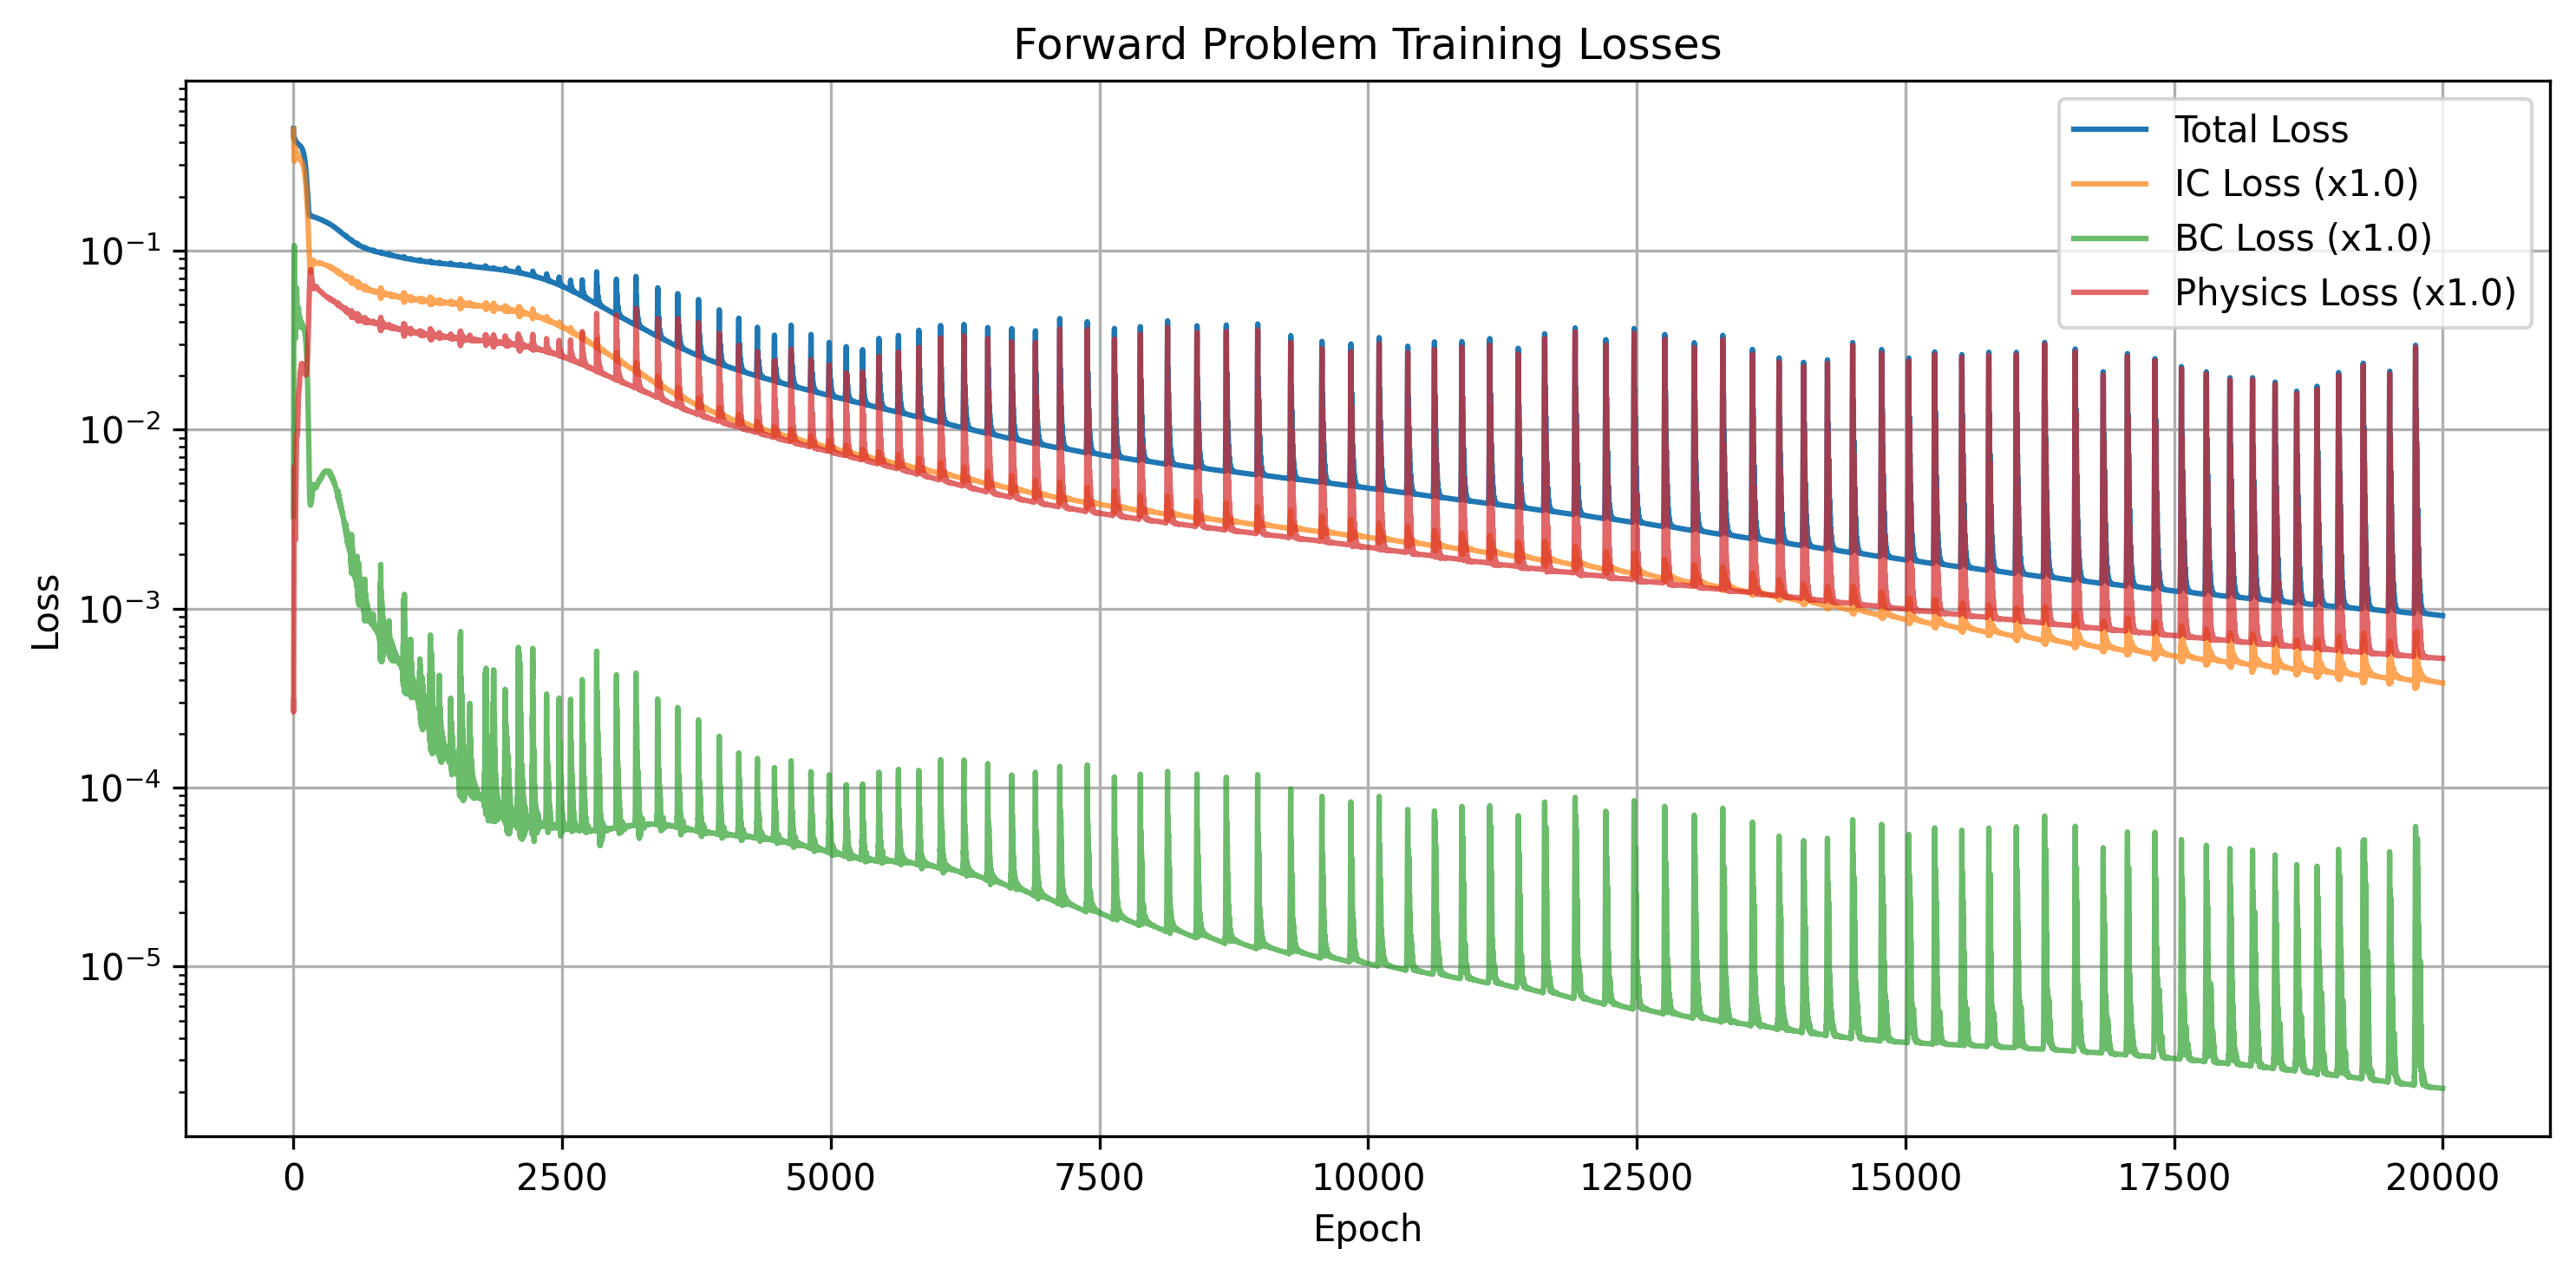

In [13]:
# Plot forward losses
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(losses_fwd_total, label="Total Loss")
plt.plot(losses_fwd_ic, label=f"IC Loss (x{lambda_ic:.1f})", alpha=0.7)
plt.plot(losses_fwd_bc, label=f"BC Loss (x{lambda_bc:.1f})", alpha=0.7)
plt.plot(losses_fwd_f, label=f"Physics Loss (x{lambda_f:.1f})", alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Forward Problem Training Losses")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# getting the reference solution from here:
# https://github.com/maziarraissi/PINNs/tree/master/appendix/Data/burgers_shock.mat
# Load reference solution
import scipy.io
ref_data = scipy.io.loadmat('burgers_shock.mat')

# Create a grid for plotting
t_grid = ref_data['t'].ravel()
x_grid = ref_data['x'].ravel()
T, X = np.meshgrid(t_grid, x_grid)

# Prepare grid points for PyTorch model
tx_eval = np.vstack([T.ravel(), X.ravel()]).T
tx_eval_torch = torch.tensor(tx_eval, dtype=torch.float32).to(device)

# Predict using the trained forward model
model_forward.eval()
with torch.no_grad():
    u_pred_forward = model_forward(tx_eval_torch)

u_pred_forward_np = u_pred_forward.cpu().numpy().reshape(X.shape)

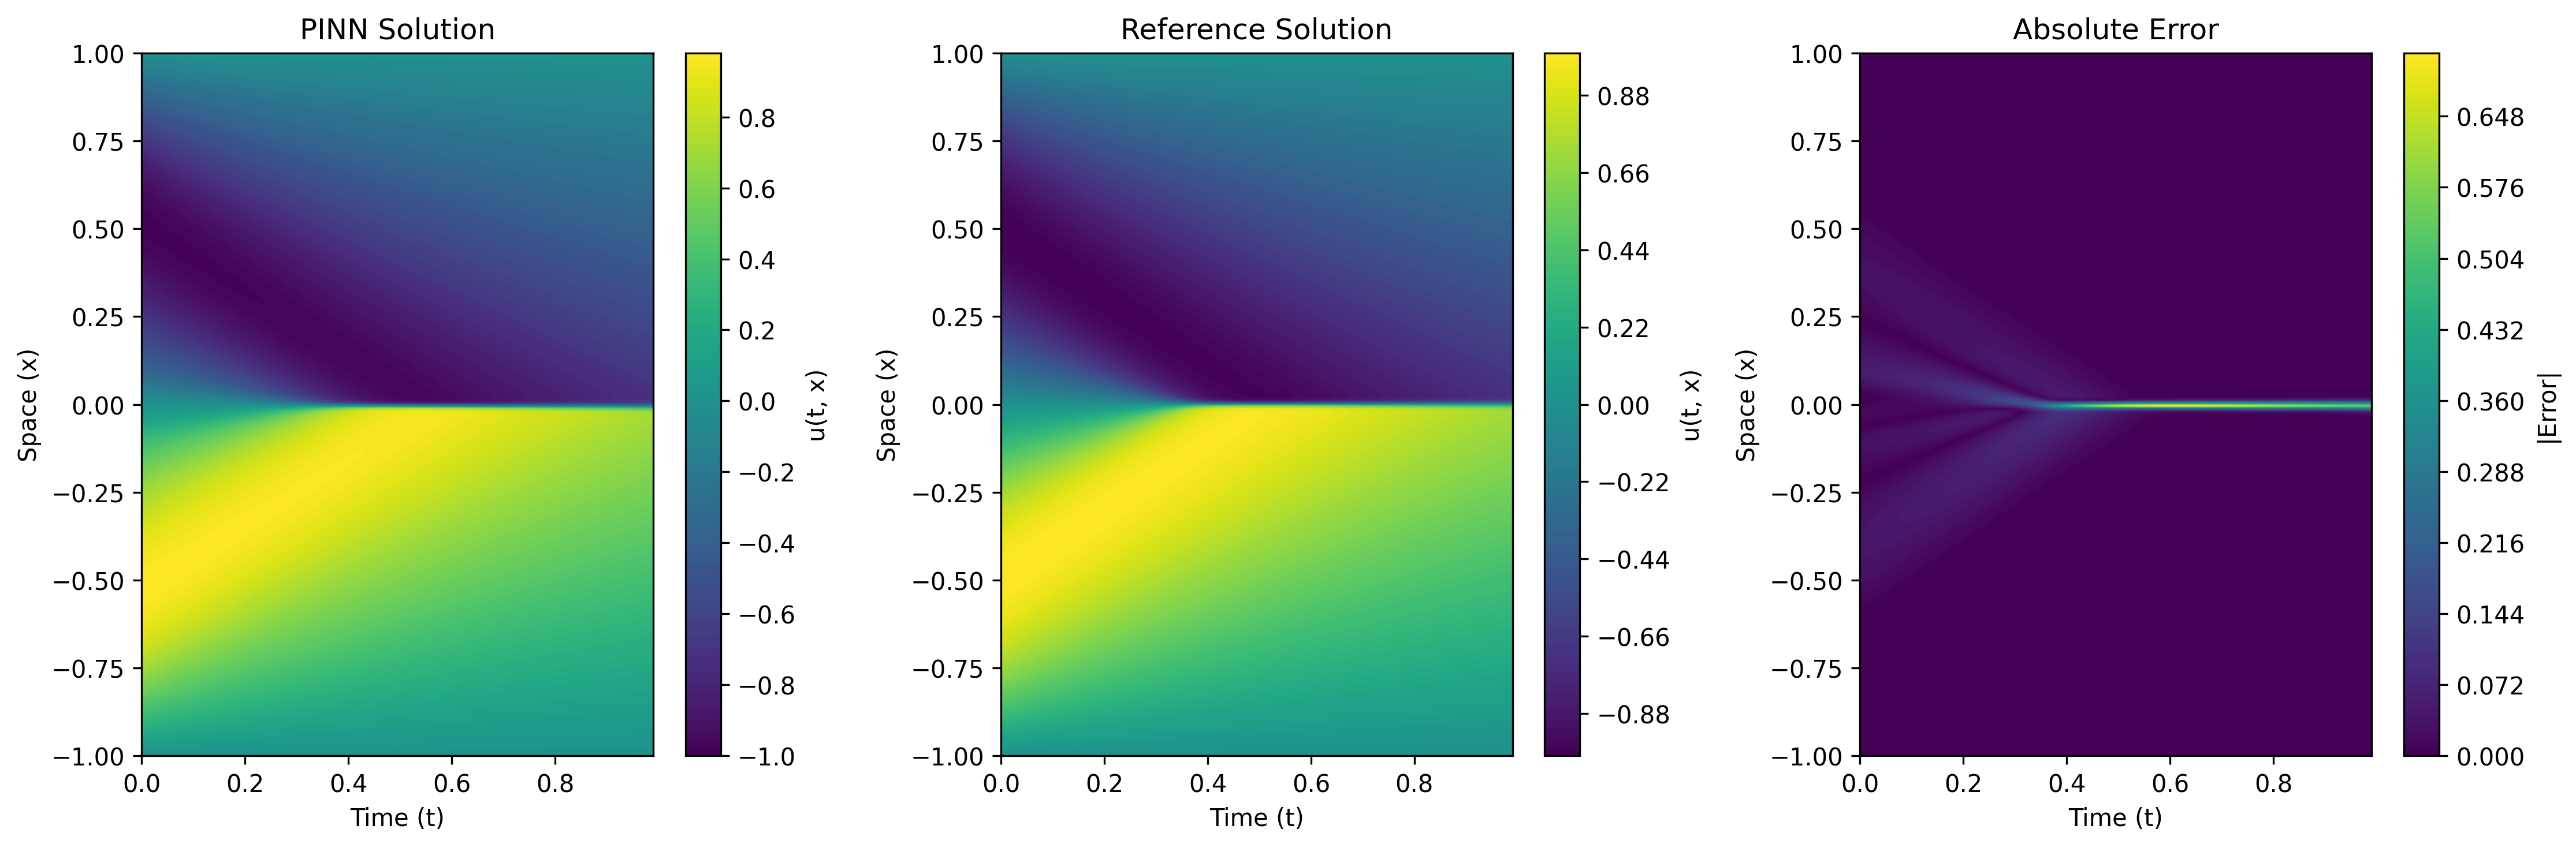

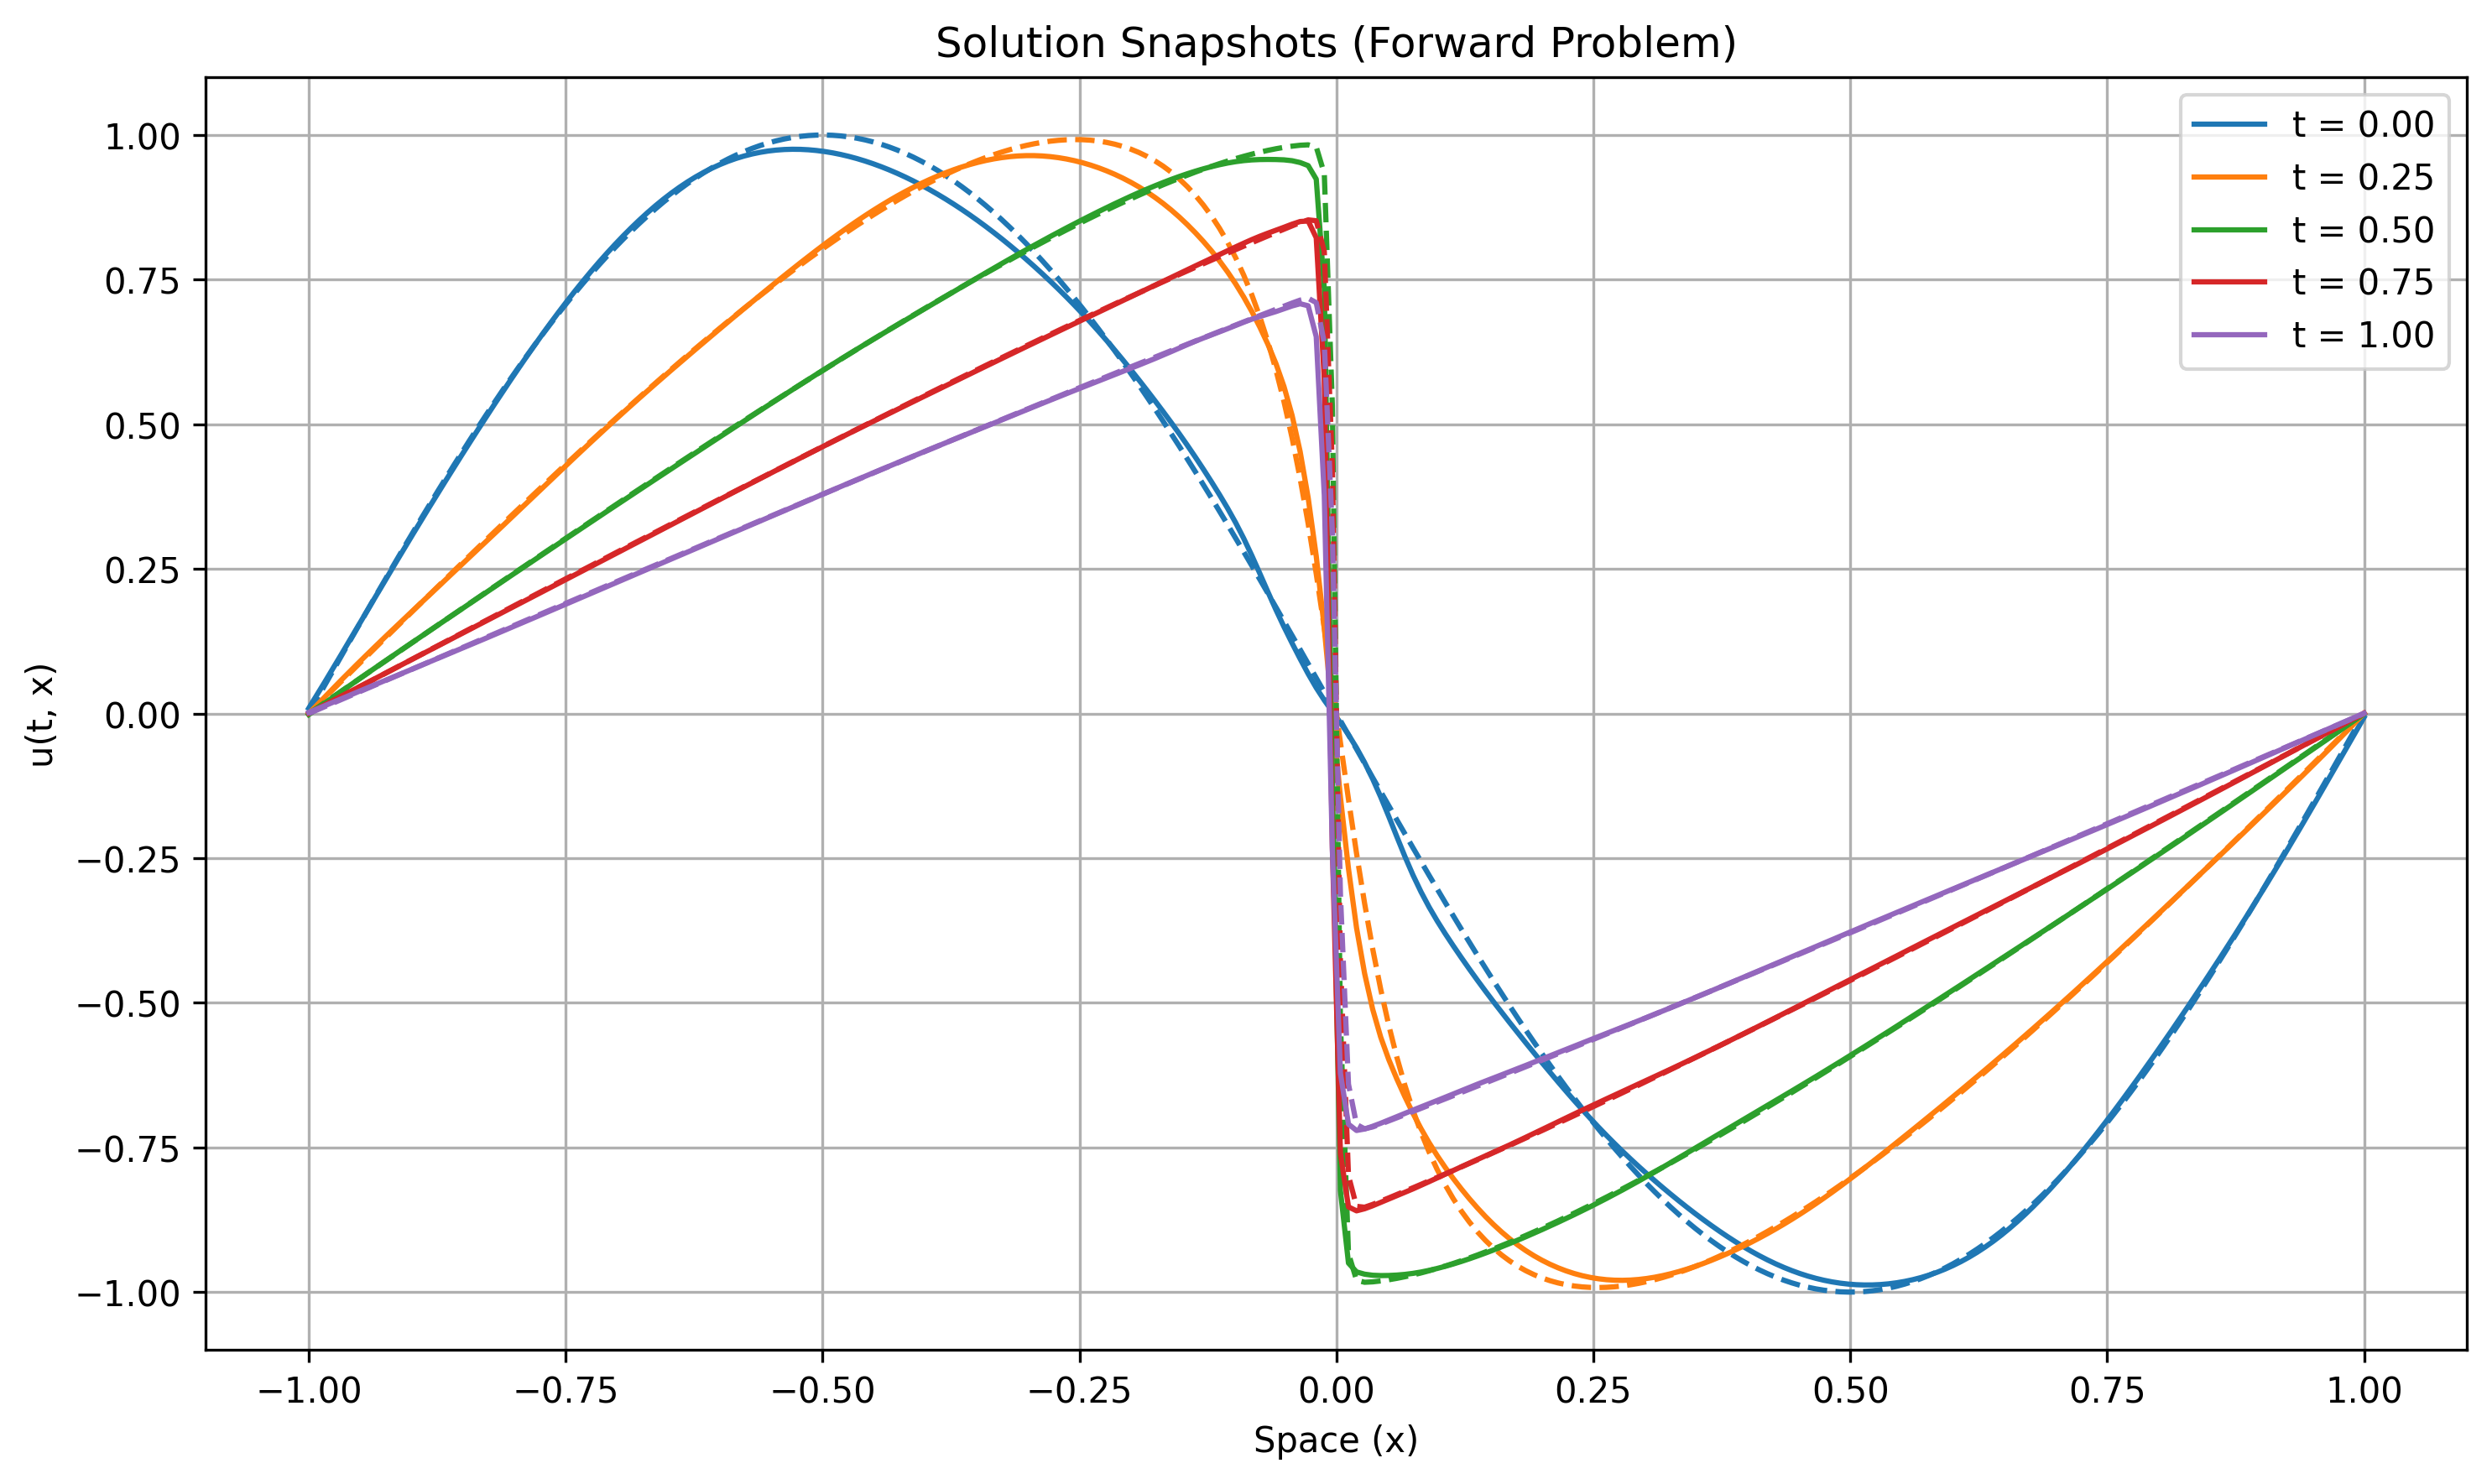

In [15]:

# Plot the predicted solution
# Create a 1x3 subplot layout
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=300)

# Plot the predicted solution
cp0 = axes[0].contourf(T, X, u_pred_forward_np, levels=100, cmap="viridis")
axes[0].set_xlabel("Time (t)")
axes[0].set_ylabel("Space (x)")
axes[0].set_title("PINN Solution")
fig.colorbar(cp0, ax=axes[0], label="u(t, x)")

# Plot the reference solution
cp1 = axes[1].contourf(T, X, ref_data['usol'], levels=100, cmap="viridis")
axes[1].set_xlabel("Time (t)")
axes[1].set_ylabel("Space (x)")
axes[1].set_title("Reference Solution")
fig.colorbar(cp1, ax=axes[1], label="u(t, x)")

# Plot the absolute error
error = np.abs(u_pred_forward_np - ref_data['usol'])
cp2 = axes[2].contourf(T, X, error, levels=100, cmap="viridis")
axes[2].set_xlabel("Time (t)")
axes[2].set_ylabel("Space (x)")
axes[2].set_title(f"Absolute Error")
fig.colorbar(cp2, ax=axes[2], label="|Error|")

plt.tight_layout()
plt.show()

# Plot snapshots at different times
plt.figure(figsize=(10, 6), dpi=300)
times_to_plot = [0.0, 0.25, 0.5, 0.75, 1.0]
for i, t_snap in enumerate(times_to_plot):
    idx = np.argmin(np.abs(t_grid - t_snap))
    plt.plot(x_grid, u_pred_forward_np[:, idx], '-', label=f"t = {t_snap:.2f}")
    plt.plot(x_grid, ref_data['usol'][:, idx], '--', color=plt.gca().lines[-1].get_color())
plt.xlabel("Space (x)")
plt.ylabel("u(t, x)")
plt.title("Solution Snapshots (Forward Problem)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Inverse Problems: Inferring Physical Parameters

PINNs shine in solving **inverse problems**, where we use observed data to infer unknown physical parameters within the governing equations.

**Example:** Inferring viscosity $\nu$ in Burger's equation.

1.  **Make Parameter Trainable:** Treat $\nu$ not as a fixed constant, but as a trainable parameter within the PyTorch framework:
    ```python
    # Initial guess for viscosity
    nu = torch.nn.Parameter(torch.tensor([0.01], device=device))
    # Add 'nu' to the optimizer's list of parameters
    optimizer = optim.Adam(list(model.parameters()) + [nu], lr=learning_rate)
    ```
2.  **Use Parameter in Physics Loss:** When calculating the physics residual $r_{\theta, \nu}$, use the *current value* of the trainable parameter $\nu$:
\begin{align}
r_{\theta, \nu} = \frac{\partial u_{pred}}{\partial t} + u_{pred} \frac{\partial u_{pred}}{\partial x} - \nu \frac{\partial^2 u_{pred}}{\partial x^2}
\end{align}
3.  **Require Measurement Data:** To infer $\nu$, you *need* some actual measurements $u_{\mathrm{observed}}(t_i, x_i)$ at specific points in the domain. Add a data fidelity term to the loss:
\begin{align}
\mathcal{L}_{\mathrm{measurements}} = \frac{1}{N_m} \sum_{i=1}^{N_m} (u_{\mathrm{pred}}(t_i, x_i) - u_{\mathrm{observed}}(t_i, x_i))^2
\end{align}
4.  **Combined Loss:** The total loss now aims to satisfy ICs/BCs, the physics (with the learnable $\nu$), *and* match the observations:
\begin{align}
\mathcal{L} = \mathcal{L}_{\mathrm{IC/BC}} + \lambda_f \mathcal{L}_{\mathrm{physics}} + \lambda_m \mathcal{L}_{\mathrm{measurements}}
\end{align}

By minimizing this combined loss, the optimizer adjusts both the network weights (to approximate $u(t, x)$) and the value of $\nu$ simultaneously, converging towards the viscosity value that best explains the observed data under the constraint of Burger's equation.

We need sparse measurements $u(t_m, x_m)$ within the domain. Let's sample these from the reference solution that we had generated.

In [16]:
num_measure = 400  # Number of measurement points

# Randomly sample grid points in the domain for measurements
idx_t = torch.randint(0, t_grid.shape[0], (num_measure,))
t_m = torch.from_numpy(t_grid)[idx_t]

idx_x = torch.randint(0, x_grid.shape[0], (num_measure,))
x_m = torch.from_numpy(x_grid)[idx_x]

# Combine time and space coordinates
tx_m = torch.cat([t_m.view(-1, 1), x_m.view(-1, 1)], dim=1).to(device).float()
u_m = torch.from_numpy(ref_data['usol'][idx_x, idx_t]).to(device).float().view(-1, 1)

print(f"Generated {num_measure} measurement points (t, x, u).")

Generated 400 measurement points (t, x, u).


In [17]:
# Re-initialize model for inverse problem
model_inverse = MLP(input_dim, hidden_dim, output_dim).to(device)

# Make viscosity nu a trainable parameter
# Initialize with a guess (e.g., slightly off from true value)
initial_nu_guess = 0.05
nu_param = torch.nn.Parameter(torch.tensor([initial_nu_guess], device=device))

# Optimizer includes both model parameters and the nu parameter
optimizer_inverse = optim.Adam(
    list(model_inverse.parameters()) + [nu_param],
    lr=1e-4,
)

print(f"Initial guess for nu: {nu_param.item():.4f}")

Initial guess for nu: 0.0500


In [18]:
# Inherit physics_loss_forward, but nu is now the trainable nu_param
def physics_loss_inverse(model, t_f, x_f, nu_parameter):
    return physics_loss_forward(
        model, t_f, x_f, nu_parameter
    )  # nu is now the trainable param


# Weight for the measurement loss (can be tuned as well)
lambda_m = 1.0

In [19]:
num_epochs_inverse = 30000  # Might need more epochs for inverse
print_every_inverse = 1000

# Store learned nu values over epochs
learned_nu_history = []

losses_inv_total = []
losses_inv_ic = []
losses_inv_bc = []
losses_inv_f = []
losses_inv_m = []

print("\n--- Starting Inverse Problem Training ---")
start_time = time.time()

for epoch in range(num_epochs_inverse):
    model_inverse.train()

    # Zero gradients
    optimizer_inverse.zero_grad()

    # --- Calculate Data Losses (IC, BC, Measurements) ---
    # IC Loss
    u_pred_ic = model_inverse(torch.cat([t_ic, x_ic], dim=1))
    loss_ic = mse_loss(u_pred_ic, u_ic)

    # BC Loss
    u_pred_bc = model_inverse(torch.cat([t_bc, x_bc], dim=1))
    loss_bc = mse_loss(u_pred_bc, u_bc)

    # Measurement Loss
    u_pred_m = model_inverse(tx_m)  # Predict at measurement points
    loss_m = mse_loss(u_pred_m, u_m)  # Compare with measured u values

    # --- Calculate Physics Loss (using trainable nu) ---
    loss_f = physics_loss_inverse(model_inverse, t_f, x_f, nu_param)

    # --- Total Loss ---
    loss = (
        lambda_ic * loss_ic
        + lambda_bc * loss_bc
        + lambda_m * loss_m
        + lambda_f * loss_f
    )

    # --- Backpropagation and Optimization ---
    loss.backward()
    optimizer_inverse.step()

    # --- Logging ---
    learned_nu_history.append(nu_param.item())
    losses_inv_total.append(loss.item())
    losses_inv_ic.append(loss_ic.item())
    losses_inv_bc.append(loss_bc.item())
    losses_inv_f.append(loss_f.item())
    losses_inv_m.append(loss_m.item())

    if (epoch + 1) % print_every_inverse == 0:
        print(
            f"Inv Epoch [{epoch + 1}/{num_epochs_inverse}], Loss: {loss.item():.4e}, "
            f"Nu: {nu_param.item():.6f} "
            f"(IC:{loss_ic.item():.2e}, BC:{loss_bc.item():.2e}, Meas:{loss_m.item():.2e}, Phys:{loss_f.item():.2e})"
        )


end_time = time.time()
final_nu = nu_param.item()
print(f"Inverse Training Finished! Time: {end_time - start_time:.2f} seconds")
print(f"==> True Viscosity (nu): {nu_true:.6f}")
print(f"==> Inferred Viscosity (nu): {final_nu:.6f}")


--- Starting Inverse Problem Training ---
Inv Epoch [1000/30000], Loss: 3.0776e-02, Nu: 0.038460 (IC:2.12e-03, BC:7.37e-04, Meas:2.28e-02, Phys:5.14e-03)
Inv Epoch [2000/30000], Loss: 1.5672e-02, Nu: 0.023080 (IC:1.01e-03, BC:6.03e-04, Meas:1.05e-02, Phys:3.58e-03)
Inv Epoch [3000/30000], Loss: 9.4400e-03, Nu: 0.017912 (IC:4.46e-04, BC:8.94e-05, Meas:6.80e-03, Phys:2.10e-03)
Inv Epoch [4000/30000], Loss: 6.3325e-03, Nu: 0.014571 (IC:2.89e-04, BC:5.20e-05, Meas:4.59e-03, Phys:1.40e-03)
Inv Epoch [5000/30000], Loss: 4.6913e-03, Nu: 0.012431 (IC:2.19e-04, BC:3.84e-05, Meas:3.32e-03, Phys:1.11e-03)
Inv Epoch [6000/30000], Loss: 3.7616e-03, Nu: 0.011059 (IC:1.96e-04, BC:3.19e-05, Meas:2.58e-03, Phys:9.55e-04)
Inv Epoch [7000/30000], Loss: 3.1406e-03, Nu: 0.010099 (IC:1.85e-04, BC:2.72e-05, Meas:2.10e-03, Phys:8.31e-04)
Inv Epoch [8000/30000], Loss: 2.7158e-03, Nu: 0.009425 (IC:1.71e-04, BC:2.40e-05, Meas:1.79e-03, Phys:7.32e-04)
Inv Epoch [9000/30000], Loss: 2.4184e-03, Nu: 0.008955 (IC:1.

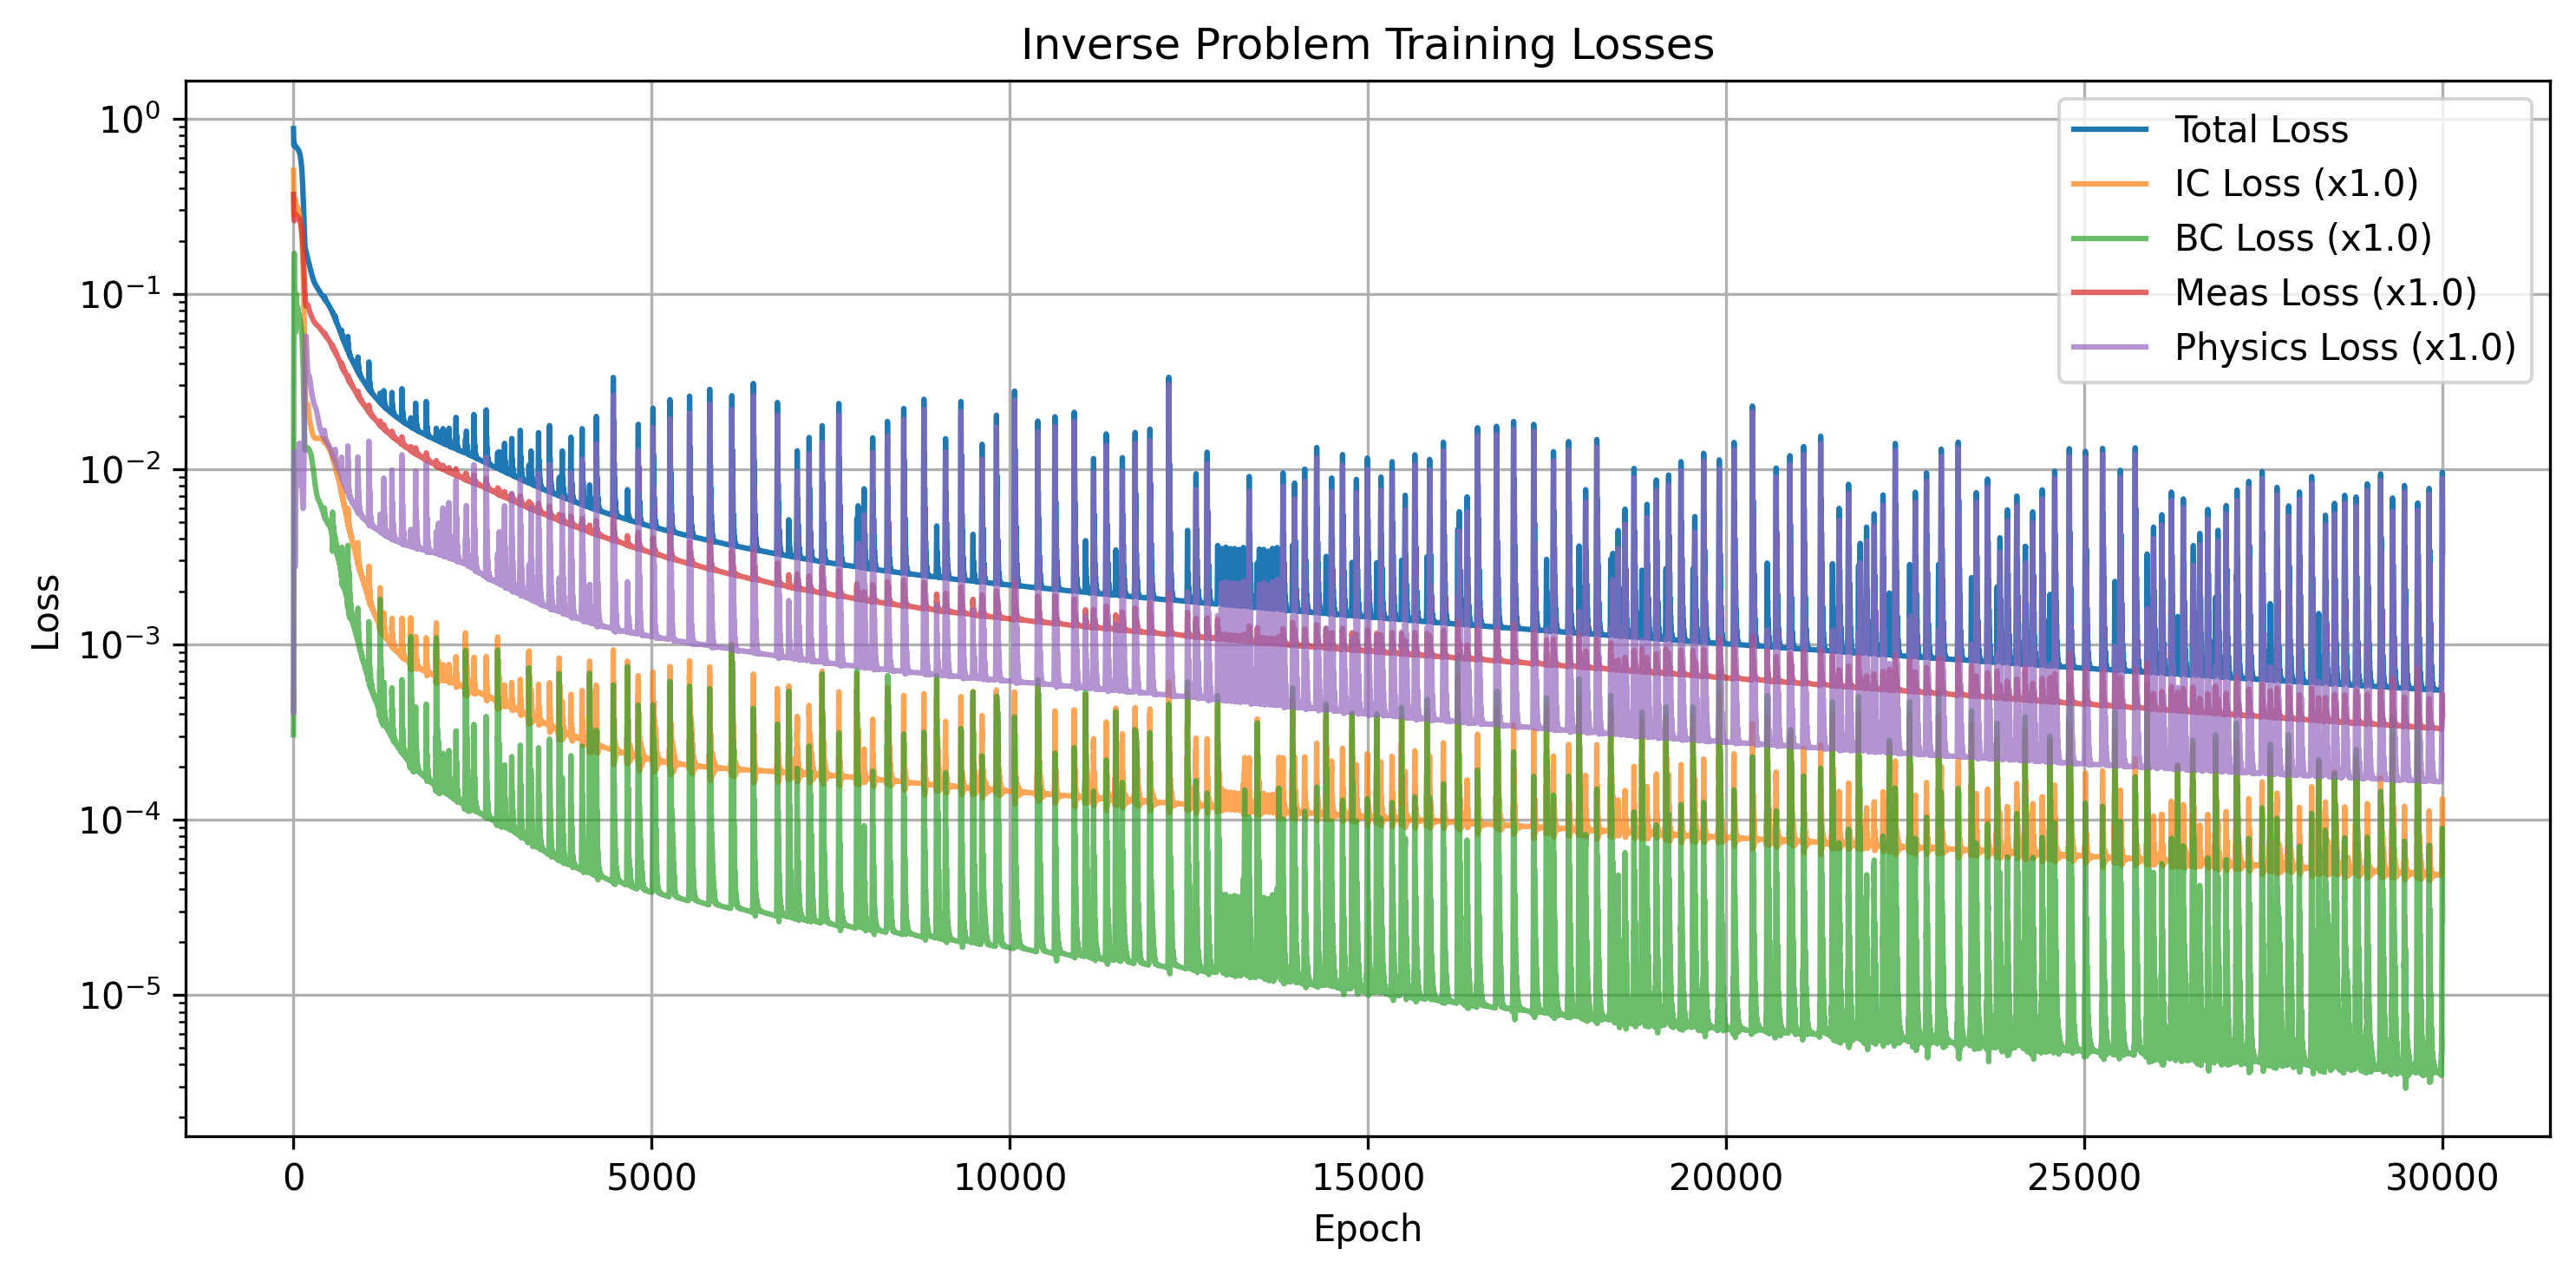

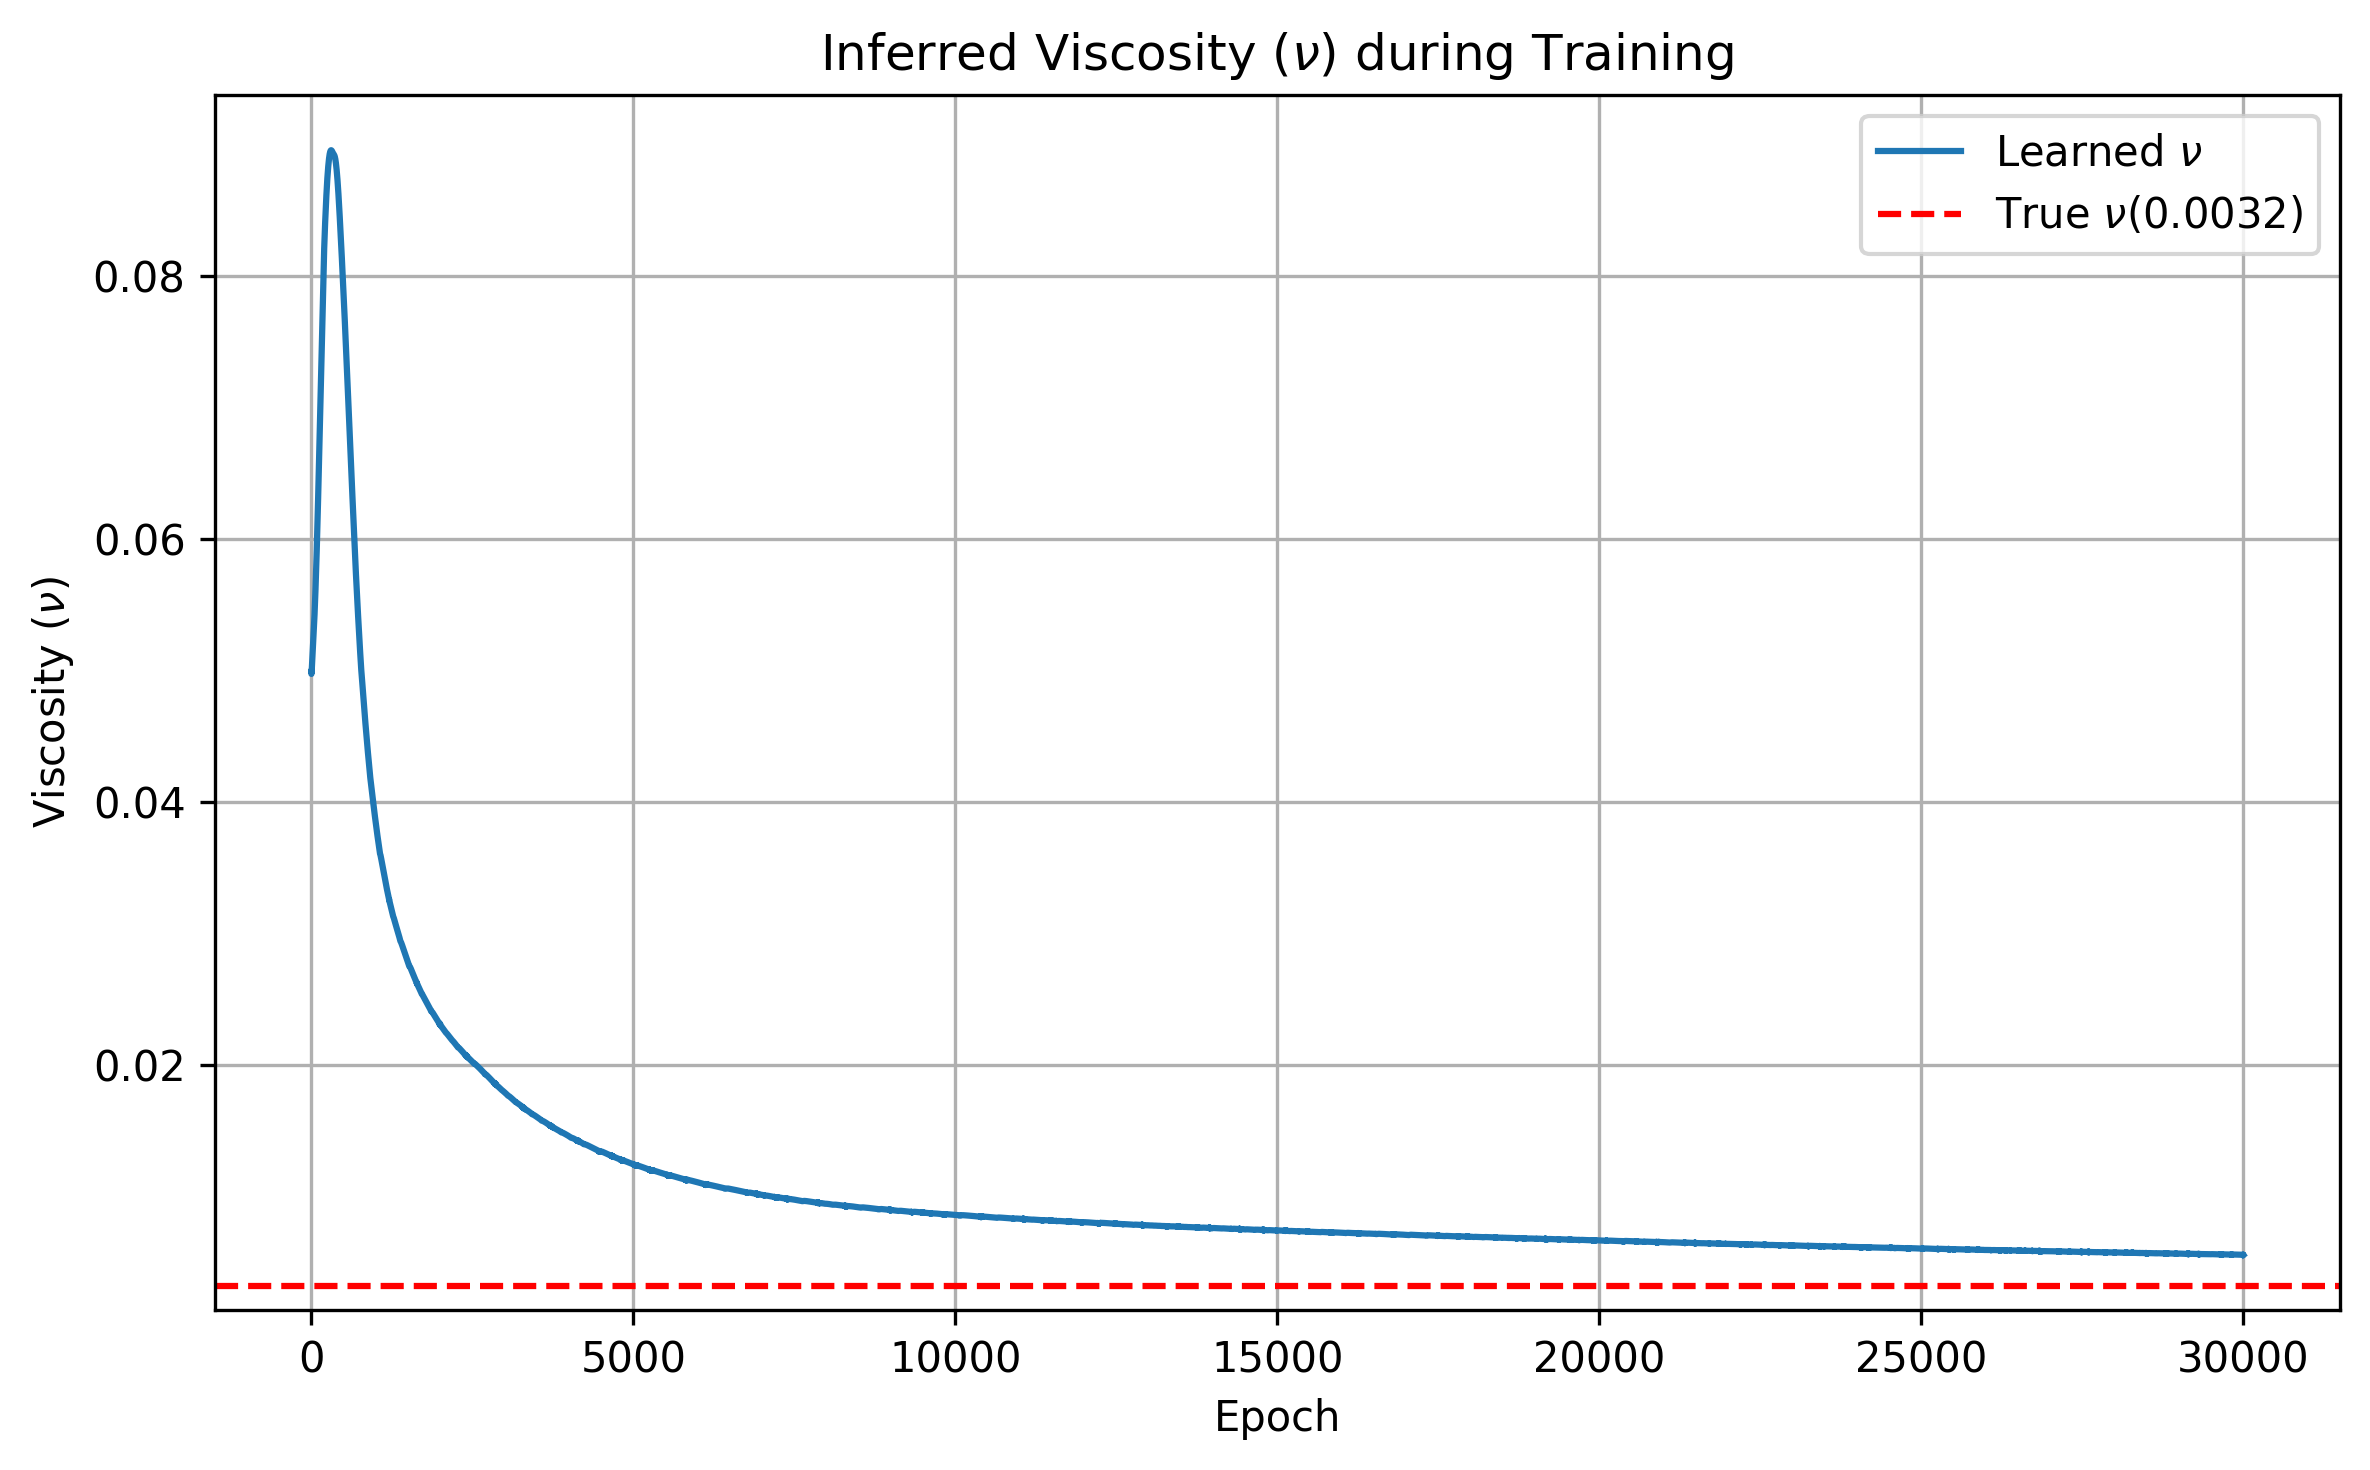

In [20]:
# Plot inverse losses
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(losses_inv_total, label="Total Loss")
plt.plot(losses_inv_ic, label=f"IC Loss (x{lambda_ic:.1f})", alpha=0.7)
plt.plot(losses_inv_bc, label=f"BC Loss (x{lambda_bc:.1f})", alpha=0.7)
plt.plot(losses_inv_m, label=f"Meas Loss (x{lambda_m:.1f})", alpha=0.7)
plt.plot(losses_inv_f, label=f"Physics Loss (x{lambda_f:.1f})", alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Inverse Problem Training Losses")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot learned nu history
plt.figure(figsize=(8, 5), dpi=300)
plt.plot(learned_nu_history, label=r"Learned $\nu$")
plt.axhline(nu_true, color="r", linestyle="--", label=r"True $\nu$" + f"({nu_true:.4f})")
plt.xlabel("Epoch")
plt.ylabel(r"Viscosity ($\nu$)")
plt.title(r"Inferred Viscosity ($\nu$) during Training")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Conclusion

PINNs offer a compelling way to integrate domain knowledge (physics) into machine learning models.

**Key Advantages:**
*   **Reduced Data Dependency:** Can often learn accurate solutions even with sparse data, as the physics provides strong constraints.
*   **Solving Ill-Posed Problems:** Effective for inverse problems where parameters need to be estimated.
*   **Handling Complex Geometries/BCs:** Neural networks are flexible function approximators.
*   **Leveraging Unlabeled Data:** Collocation points for the physics loss don't require known $u$ values.

PINNs represent a significant step towards building more robust, interpretable, and data-efficient AI models for scientific and engineering applications. We hope we've demonstrated the power of PINNs in solving forward and inverse problems and hope you'll use them in your own work. As always, we welcome any feedback or questions you may have.